In [19]:
import gcsfs
import zarr
import allel
import dask.array as da
import numpy as np

In [10]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
from dask.distributed import Client
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://10.33.164.118:42257
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-71f2bbc8-8863-11ea-811e-96529bfe3d58
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.164.118:42257 Dashboard: /user/alimanfoo@googlemail.com/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register tcp://10.33.187.2:37665
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.187.2:37665
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.181.2:33411
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.181.2:33411
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.180.2:35021
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.180.2:35021
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.182.2:43749
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.182.2:43749
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.183.2:36133
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.183.2:36133
distributed.c

In [11]:
gcs_anon = gcsfs.GCSFileSystem(token='anon', access='read_only')

In [12]:
storage_path = 'ag1000g-release/phase2.AR1/variation/main/zarr/biallelic/ag1000g.phase2.ar1.pass.biallelic'

In [13]:
store = gcsfs.mapping.GCSMap(storage_path, gcs=gcs_anon, check=False, create=False)

In [14]:
callset = zarr.open_consolidated(store=store)

Here are some genotype calls, these are the input data we want to perform an SVD on...

In [15]:
genotypes = da.from_array(callset['3R/calldata/GT'])
genotypes

,Array,Chunk
Bytes,24.56 GB,63.96 MB
Shape,"(10752701, 1142, 2)","(524288, 61, 2)"
Count,400 Tasks,399 Chunks
Type,int8,numpy.ndarray


In order to run an SVD, we first need to perform a transformation on these data. This transformation simply counts the number of non-zero values along the third dimension. This is a crude transformation that only works for biallelic variants with very little missingness, but will suffice for this example.

In [16]:
gn = da.sum(genotypes > 0, axis=2)
gn

dask.array<sum-aggregate, shape=(10752701, 1142), dtype=int64, chunksize=(524288, 61), chunktype=numpy.ndarray>

N.B., the **rows** of this array are the **features** (genetic variations) and the **columns** of this array are the **observations** (individual mosquitoes).

We want to do an SVD to identify structure in the genetic similarity between individuals. I.e., we want to end up with an array of coordinates of shape (1142, *n*) where *n* is the number of dimensions we have reduced to (usually 20 is enough).

Before we can run an SVD we need to get rid of any invariant features. Simple way to do this is to compare all values to the first value in the row.

In [20]:
is_informative = da.any(gn != gn[:, 0, None], axis=1).compute()
np.count_nonzero(is_informative)

10751847

In [21]:
gn_informative = da.compress(is_informative, gn, axis=0)
gn_informative

dask.array<getitem, shape=(10751847, 1142), dtype=int64, chunksize=(524285, 61), chunktype=numpy.ndarray>

Also, before we can run an SVD, we need to center and scale these data. A standard scaler should be sufficient, e.g.:

In [22]:
m = da.mean(gn_informative, axis=1, keepdims=True)
s = da.std(gn_informative, axis=1, keepdims=True)
gn_scaled = (gn_informative - m) / s
gn_scaled

dask.array<truediv, shape=(10751847, 1142), dtype=float64, chunksize=(524285, 61), chunktype=numpy.ndarray>

The array `gn_scaled` is now ready for SVD.

Here's what we expect it to look like, based on downsampling the data and computing the SVD in memory...

In [23]:
gn_small = gn_scaled[::1000].compute()
gn_small

distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


array([[-0.02960446, -0.02960446, -0.02960446, ..., -0.02960446,
        -0.02960446, -0.02960446],
       [-0.02960446, -0.02960446, -0.02960446, ..., -0.02960446,
        -0.02960446, -0.02960446],
       [-0.02960446, -0.02960446, -0.02960446, ..., -0.02960446,
        -0.02960446, -0.02960446],
       ...,
       [-0.04188539, -0.04188539, -0.04188539, ..., -0.04188539,
        -0.04188539, -0.04188539],
       [-0.06631393, -0.06631393, -0.06631393, ..., -0.06631393,
        -0.06631393, -0.06631393],
       [-0.04188539, -0.04188539, -0.04188539, ..., -0.04188539,
        -0.04188539, -0.04188539]])

In [26]:
gn_small.shape

(10752, 1142)

In [24]:
import scipy.linalg

In [25]:
u, s, v = scipy.linalg.svd(gn_small, full_matrices=False)

In [27]:
coords = s * v.T
coords.shape

(1142, 1142)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import pandas as pd

Read in some sample metadata, this allows us to colour the samples by country of origin...

In [34]:
with gcs_anon.open('ag1000g-release/phase2.AR1/samples/samples.meta.txt') as f:
    df_samples = pd.read_csv(f, sep='\t')
df_samples.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


In [35]:
import seaborn as sns
reds = sns.color_palette('Reds', 5)
blues = sns.color_palette('Blues', 4)
greens = sns.color_palette('Greens', 2)
browns = sns.color_palette('YlOrBr', 4)
purples = sns.color_palette('Purples', 2)
greys = sns.color_palette('Greys', 3)
pop_colors = {
    'AOcol': reds[4],
    'GHcol': reds[3],
    'BFcol': reds[2],
    'CIcol': reds[1],
    'GNcol': reds[0],
    'CMgam': blues[3],
    'GHgam': blues[2],
    'BFgam': blues[1],
    'GNgam': blues[0],
    'GW': browns[1],
    'GM': browns[2],
    'GAgam': greens[1],
    'UGgam': greens[0],
    'FRgam': purples[1],
    'GQgam': purples[0],
    'KE': greys[1],
}

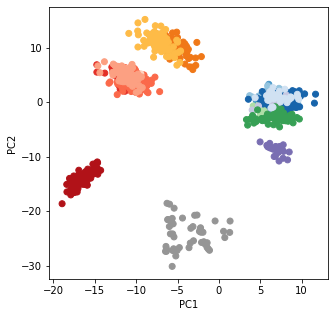

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
x = coords[:, 0]
y = coords[:, 1]
c = [pop_colors[p] for p in df_samples.population]
ax.scatter(x, y, c=c)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

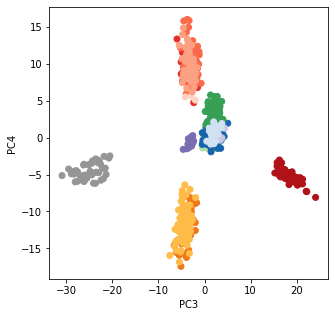

distributed.scheduler - INFO - Remove worker tcp://10.33.185.2:40129
distributed.core - INFO - Removing comms to tcp://10.33.185.2:40129


In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
x = coords[:, 2]
y = coords[:, 3]
ax.scatter(x, y, c=c)
ax.set_xlabel('PC3')
ax.set_ylabel('PC4');